# Python - Parcial Final

A continuación se detallan algunas funciones para leer cada archivo txt generado de los puntos a y b, 

In [1]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D     # noqa: F401
from matplotlib import animation

def load_time_blocks(path):
    """Lee archivo por bloques (# Tiempo: ...) y devuelve (blocks, times)."""
    blocks, times = [], []
    cur, tcur = [], np.nan
    with open(path, 'r', encoding='utf-8') as f:
        for raw in f:
            line = raw.strip()
            if not line:
                if cur:
                    blocks.append(pd.DataFrame(cur, columns=['k','zE','zH','Ex','Hy']))
                    times.append(tcur)
                    cur, tcur = [], np.nan
                continue
            if line.startswith('#'):
                low = line.lower()
                if low.startswith('# tiempo'):
                    try:
                        tcur = float(line.split(':', 1)[1].strip())
                    except:
                        tcur = np.nan
                continue
            parts = line.replace(',', ' ').split()
            if len(parts) >= 5:
                k, zE, zH, Ex, Hy = int(parts[0]), float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])
                cur.append([k, zE, zH, Ex, Hy])
    if cur:
        blocks.append(pd.DataFrame(cur, columns=['k','zE','zH','Ex','Hy']))
        times.append(tcur)
    return blocks, np.array(times, dtype=float)


def make_anim_3d(blocks, times, fps=20, interval_ms=50, frame_step=1, normalize=False,
                 elev=18, azim=-58):
    """Crea animación 3D (matplotlib.animation.FuncAnimation)."""
    # Submuestreo de frames
    idx_frames = np.arange(0, len(blocks), max(1, int(frame_step)))

    zE_list = [blocks[i]['zE'].to_numpy() for i in idx_frames]
    zH_list = [blocks[i]['zH'].to_numpy() for i in idx_frames]
    Ex_list = [blocks[i]['Ex'].to_numpy() for i in idx_frames]
    Hy_list = [blocks[i]['Hy'].to_numpy() for i in idx_frames]

    t_arr = times.copy()
    if np.all(np.isnan(t_arr)):  # si no hay tiempos en archivo, usa índice
        t_arr = np.arange(len(blocks), dtype=float)
    t_arr = t_arr[idx_frames]

    # Normalización (opcional)
    if normalize:
        m = max(np.max(np.abs(np.concatenate(Ex_list))), np.max(np.abs(np.concatenate(Hy_list))))
        if m > 0:
            Ex_list = [Ex/m for Ex in Ex_list]
            Hy_list = [Hy/m for Hy in Hy_list]

    # Límites globales fijos
    zmin = min([z.min() for z in zE_list + zH_list])
    zmax = max([z.max() for z in zE_list + zH_list])
    ymin = min([e.min() for e in Ex_list] + [0])
    ymax = max([e.max() for e in Ex_list] + [0])
    z2min = min([h.min() for h in Hy_list] + [0])
    z2max = max([h.max() for h in Hy_list] + [0])

    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111, projection='3d')

    # Curvas iniciales
    lineE, = ax.plot(zE_list[0], Ex_list[0], np.zeros_like(Ex_list[0]), linewidth=2, label='Eₓ(z)')
    lineH, = ax.plot(zH_list[0], np.zeros_like(Hy_list[0]), Hy_list[0], linewidth=2, label='Hᵧ(z)')

    ax.set_xlabel('Z'); ax.set_ylabel('Eje X (Eₓ)'); ax.set_zlabel('Eje Y (Hᵧ)')
    ax.view_init(elev=elev, azim=azim)
    ax.legend(loc='upper right')
    ax.set_xlim(zmin, zmax)
    ax.set_ylim(ymin, ymax)
    ax.set_zlim(z2min, z2max)
    title = ax.set_title(f"t ≈ {t_arr[0]:.6f}")

    def update(i):
        lineE.set_data(zE_list[i], Ex_list[i])
        lineE.set_3d_properties(np.zeros_like(Ex_list[i]))
        lineH.set_data(zH_list[i], np.zeros_like(Hy_list[i]))
        lineH.set_3d_properties(Hy_list[i])
        title.set_text(f"t ≈ {t_arr[i]:.6f}")
        return lineE, lineH, title

    anim = animation.FuncAnimation(fig, update, frames=len(idx_frames),
                                   interval=interval_ms, blit=False)
    return fig, anim


Encontrados 6 archivos:
  - em_all_periodic.txt
  - Punto1\em_all_periodic.txt
  - Punto2a\em_all_dirichlet.txt
  - Punto2b\Sim_Pa_beta1.txt
  - Punto2b\Sim_Pa_beta2.txt
  - Punto2b\Sim_Pa_beta3.txt

Procesando: em_all_periodic.txt
  GIF guardado en: ..\Results\em_all_periodic.gif

Procesando: Punto1\em_all_periodic.txt
  GIF guardado en: ..\Results\Punto1\em_all_periodic.gif

Procesando: Punto2a\em_all_dirichlet.txt
  GIF guardado en: ..\Results\Punto2a\em_all_dirichlet.gif

Procesando: Punto2b\Sim_Pa_beta1.txt
  GIF guardado en: ..\Results\Punto2b\Sim_Pa_beta1.gif

Procesando: Punto2b\Sim_Pa_beta2.txt
  GIF guardado en: ..\Results\Punto2b\Sim_Pa_beta2.gif

Procesando: Punto2b\Sim_Pa_beta3.txt


KeyboardInterrupt: 

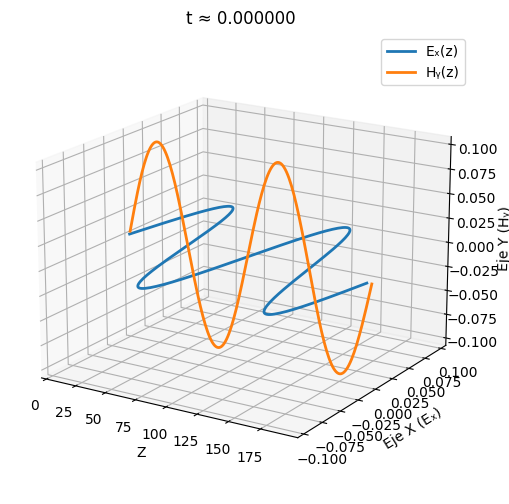

In [2]:
# Carpeta de entrada y salida (ajusta si estás en otro nivel)
in_dir = "../output"    # antes tenías ../output; usa el que te corresponda
out_dir = "../Results"  # idem

os.makedirs(out_dir, exist_ok=True)

# Parámetros de animación
FPS = 20
INTERVAL_MS = 50
FRAME_STEP = 1
NORMALIZE = False

# Recorre recursivamente output/ y procesa todos los .txt
txt_files = []
for dirpath, _, filenames in os.walk(in_dir):
    for fn in filenames:
        if fn.lower().endswith(".txt"):
            txt_files.append(os.path.join(dirpath, fn))

if not txt_files:
    print(f"No se encontraron .txt en {in_dir}")
else:
    print(f"Encontrados {len(txt_files)} archivos:")
    for p in txt_files:
        print("  -", os.path.relpath(p, in_dir))

    for path in txt_files:
        # Ruta relativa respecto a in_dir (p.ej. "Punto2b/Sim_Pa_beta1.txt")
        rel_path = os.path.relpath(path, in_dir)
        rel_dir  = os.path.dirname(rel_path)          # p.ej. "Punto2b"
        base     = os.path.splitext(os.path.basename(path))[0]

        # Directorio espejo en Results/ (crearlo si no existe)
        dest_dir = os.path.join(out_dir, rel_dir)     # p.ej. "Results/Punto2b"
        os.makedirs(dest_dir, exist_ok=True)

        out_gif = os.path.join(dest_dir, base + ".gif")
        out_mp4 = os.path.join(dest_dir, base + ".mp4")

        print("\nProcesando:", rel_path)
        try:
            blocks, times = load_time_blocks(path)
            if not blocks:
                print("  (sin datos) – omitido.")
                continue

            fig, anim = make_anim_3d(blocks, times,
                                     fps=FPS, interval_ms=INTERVAL_MS,
                                     frame_step=FRAME_STEP, normalize=NORMALIZE)

            # # MP4 (si hay ffmpeg)
            # try:
            #     anim.save(out_mp4, writer="ffmpeg", fps=FPS, dpi=150)
            #     print("  MP4 guardado en:", os.path.relpath(out_mp4))
            # except Exception as e:
            #     print("  No se pudo guardar MP4 (ffmpeg no disponible?):", e)

            # GIF (Pillow)
            try:
                anim.save(out_gif, writer=animation.PillowWriter(fps=FPS))
                print("  GIF guardado en:", os.path.relpath(out_gif))
            except Exception as e:
                print("  No se pudo guardar GIF:", e)

            plt.close(fig)

        except Exception as e:
            print("  ERROR procesando", rel_path, "->", e)

    print("\nListo. Animaciones en:", out_dir)
